# Instrument classification using deep learning techniques

Author: Abhishek Dutta

Email: abhishek.dutta1337@gmail.com 


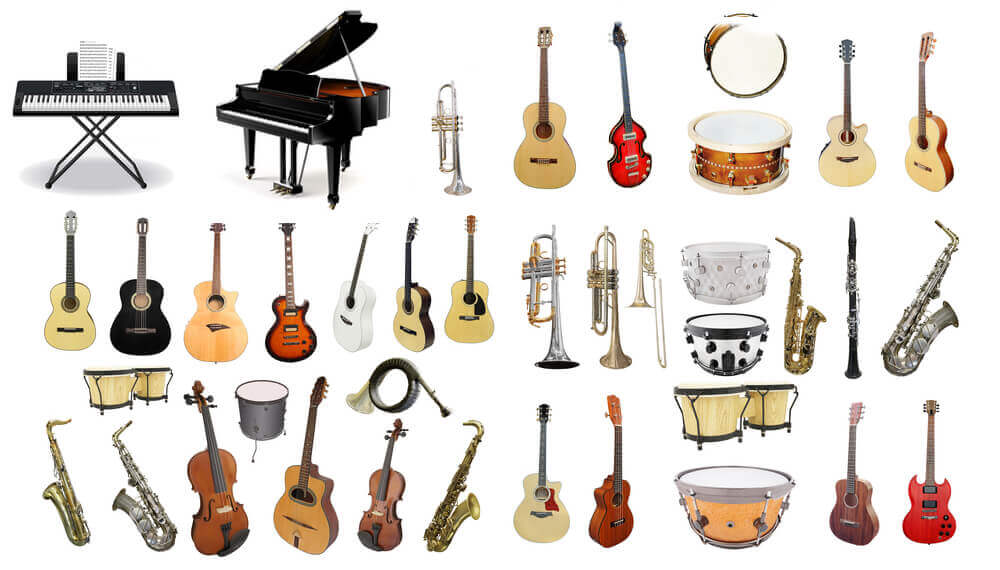


> Picture credits: https://www.musicalwiz.com/types-of-musical-instruments/




# Project Objective

The objective of this project is to classify musical instruments from audio data using deep learning. 

Additionally, this project would also try to explain the existing solution for the problem statement, try to optimize the existing solution and provide a comparison between the optimized and existing solutions.

# Introduction

The existing solution is taken from https://github.com/seth814/Audio-Classification. It provides the steps for data pre-processing, exploratory data analysis and modelling using deep learning methods such as convolutional neural networks (CNNs) and recurrent neural networks (RNNs).

The key idea is that the neural networks try to learn patterns and correlations which exist in the audio data to predict the musical instruments from an unseen audio file.


### Data source & description

Originally, the dataset belongs to https://www.kaggle.com/competitions/freesound-audio-tagging/data which is a more generalized audio dataset consisting of audio files for sounds like finger snapping, fireworks, laughter, knocks etc. but for this project, the idea is to utilize a subset of that data, particularly corresponding to musical instruments. The subset is available in the GitHub repo mentioned above and it consists of around <b>300 .wav</b> files, which contain the recordings of <b>10 different musical instruments</b>.

The musical instruments are as follows:

* Bass drum
* Acoustic guitar
* Hi-hat
* Clarinet
* Flute
* Saxophone
* Double bass
* Violin/Fiddle
* Cello
* Snare drum

### Fetching data from GitHub repo

In [1]:
!git clone https://github.com/seth814/Audio-Classification
%cd Audio-Classification
!git checkout 404f2a6f989cec3421e8217d71ef070f3593a84d
!rm LICENSE README.md eda.py model.py requirements.txt slides.pptx
%cd ..

Cloning into 'Audio-Classification'...
remote: Enumerating objects: 549, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 549 (delta 8), reused 0 (delta 0), pack-reused 534
Receiving objects: 100% (549/549), 100.03 MiB | 30.36 MiB/s, done.
Resolving deltas: 100% (121/121), done.
/kaggle/working/Audio-Classification
Note: switching to '404f2a6f989cec3421e8217d71ef070f3593a84d'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 404f2a6 added tqdm
/ka

We will be using some helper functions from the python_speech_features library. The functions are mfcc and logbank.

In [2]:
!pip install python_speech_features

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5889 sha256=eeb0c26dba969bbe68377afdd21cccf752174c345ca61f8b890da1299b28fea8
  Stored in directory: /root/.cache/pip/wheels/c7/c4/6e/16c5e5ad7fb1ecab3193251067558ef8fa0f01e39b5a213e21
Successfully built python_speech_features


# Exploratory Data Analysis

### Imports and plotting functions

There are four kinds of plotting functions that are defined in the below cell.

<b>1. Time series (simple waveform)</b>

The audio waveform, which is a raw representation of the audio signal across time, is frequently represented in audio analytics using time series. To extract valuable features that may be applied to audio classification, voice recognition, and other audio-related tasks, this waveform can be studied using a variety of techniques.

<b>2. Fast Fourier Transforms</b>

A time-domain signal is converted into its frequency-domain representation using the mathematical process of FFT. This method is used to examine the audio waveform's frequency content. FFT is used in audio analytics to extract features including spectrum peaks, spectral moments, and spectral entropy as well as to identify the various frequencies present in an audio sample.

<b>3. Filter Bank Coefficients</b>

A group of features called Filter Bank Coefficients (FBC) are taken from an audio signal using a bank of filters. These filters are made to simulate the human ear's frequency response, which responds differently to different frequencies. After that, each filter's output is processed to obtain important characteristics including each band's energy, centroid frequency, and spectral flatness. Speech recognition and music genre identification frequently employ FBC.

<b>4. Mel Frequency Cepstral Coefficients</b>

In audio analytics, the feature extraction method known as MFCC is frequently employed. Its foundation is the notion that the nonlinear processing of sound by the human auditory system and the unequal spacing of the most important frequency bands for audio perception. Applying a bank of filters to the audio signal before calculating the logarithm of the energy in each filter output is how the MFCC is calculated. The obtained features are then subjected to a Discrete Cosine Transform (DCT) to provide a collection of coefficients that are frequently applied to speech recognition and audio classification applications. Speaker identification, voice recognition, and emotion recognition are all common uses for MFCC.

In [3]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
import librosa
import time

def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fft(fft):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstral Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

### Reading in the data file

The 'instruments.csv' file is a two column file which maps each of the .wav file to the corresponding musical instrument that is detected in the audio file. This is basically the ground truth for the classification task.

In [4]:
df = pd.read_csv('Audio-Classification/instruments.csv')
df

,fname,label
0,5388d14d.wav,Saxophone
1,c685f05f.wav,Saxophone
2,36d20ab5.wav,Saxophone
3,d6665734.wav,Saxophone
4,7352e28f.wav,Saxophone
...,...,...
295,3c713bcf.wav,Clarinet
296,2fc00271.wav,Clarinet
297,b0c06255.wav,Clarinet
298,71c6451f.wav,Clarinet


In [5]:
df.set_index('fname', inplace=True)

# For calculating the length of the audio in seconds, for each wav file
for f in df.index:
    rate, signal = wavfile.read('Audio-Classification/wavfiles/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

### All unique target classes corresponding to the instruments

In [6]:
classes

['Acoustic_guitar',
 'Bass_drum',
 'Cello',
 'Clarinet',
 'Double_bass',
 'Flute',
 'Hi-hat',
 'Saxophone',
 'Snare_drum',
 'Violin_or_fiddle']

### Average duration (in seconds) of .wav files corresponding to each class 

In [7]:
class_dist

label
Acoustic_guitar     6.948667
Bass_drum           1.937333
Cello               5.000667
Clarinet            6.596000
Double_bass         3.206000
Flute               8.054667
Hi-hat              3.357333
Saxophone           7.124000
Snare_drum          3.987333
Violin_or_fiddle    4.530000
Name: length, dtype: float64

### Distribution of classes

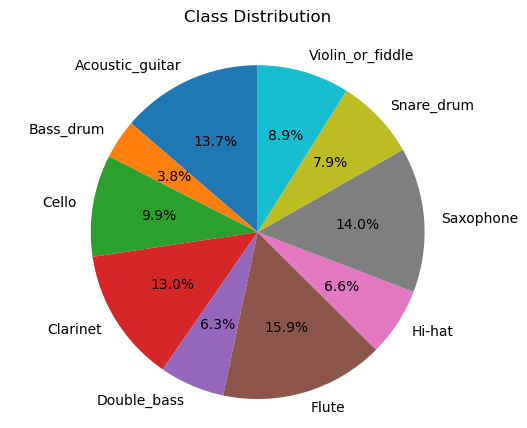

In [8]:
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.05)
ax.pie(class_dist, 
       labels=class_dist.index, 
       autopct='%1.1f%%',
       shadow=False,
       startangle=90)
ax.axis('equal')
plt.show()
df.reset_index(inplace=True)

In [9]:
# Function which calcualtes FFT of a given signal and sampling rate
def calc_fft(y, rate):
    n = len(y)
    # Magnitude and frequency component

    # When we calculate the FFT, it returns a complex number. The real part of that number
    # is the magnitude
    freq = np.fft.rfftfreq(n, d=1/rate) # d is basically the time that passes between each signal
    mag = abs(np.fft.rfft(y)/n) # dividing by 'n' so that we normalize as per the length of the signal

    return (mag,freq)

In [10]:
# Variables that will store the results
signals = {}
fft = {}
fbank = {}
mfccs = {}

### Plotting time series, fourier transforms, filter bank coefficients and mel frequency cepstral coefficients

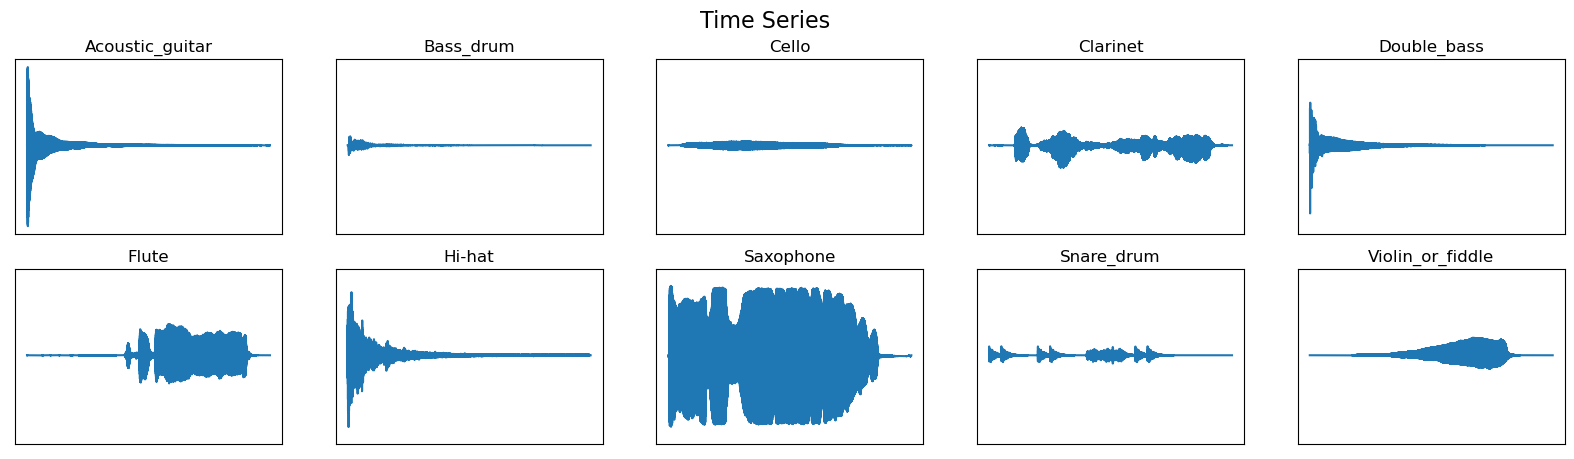

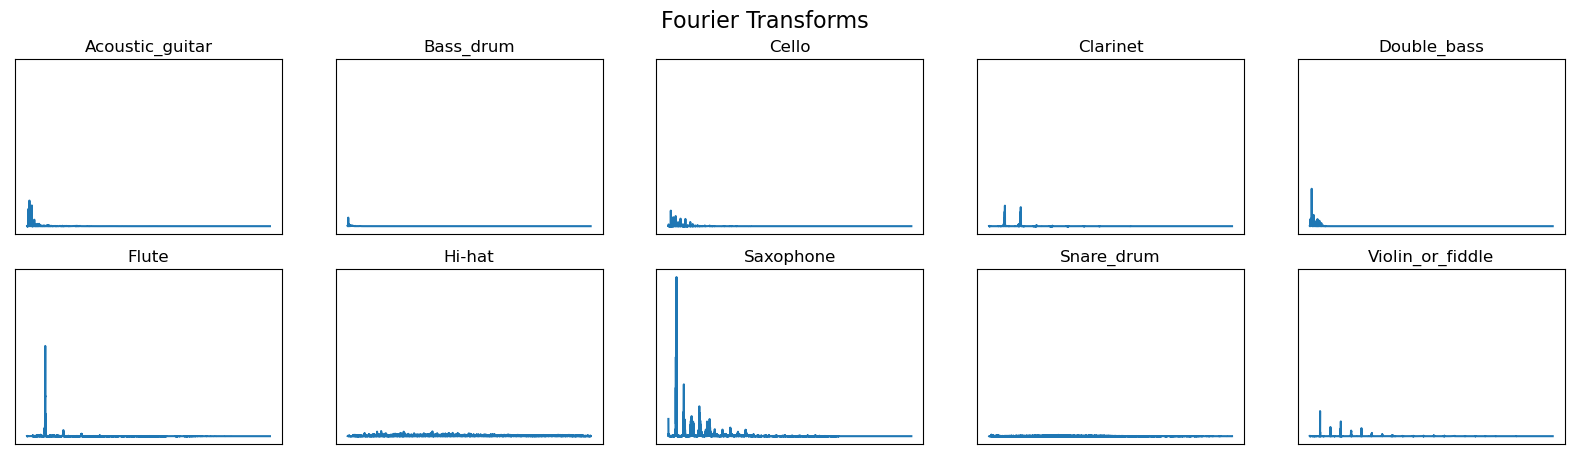

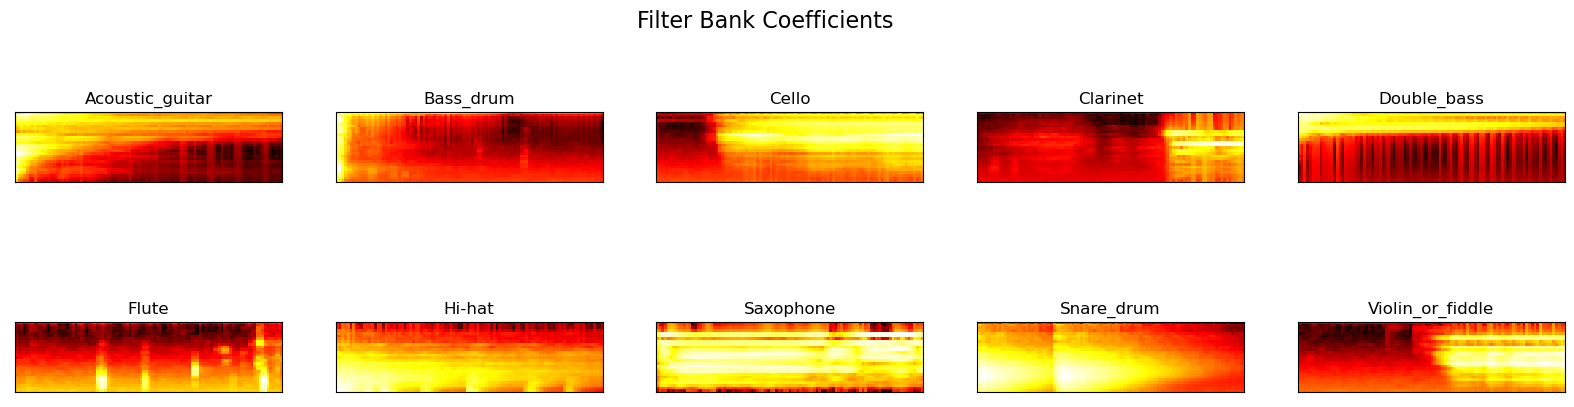

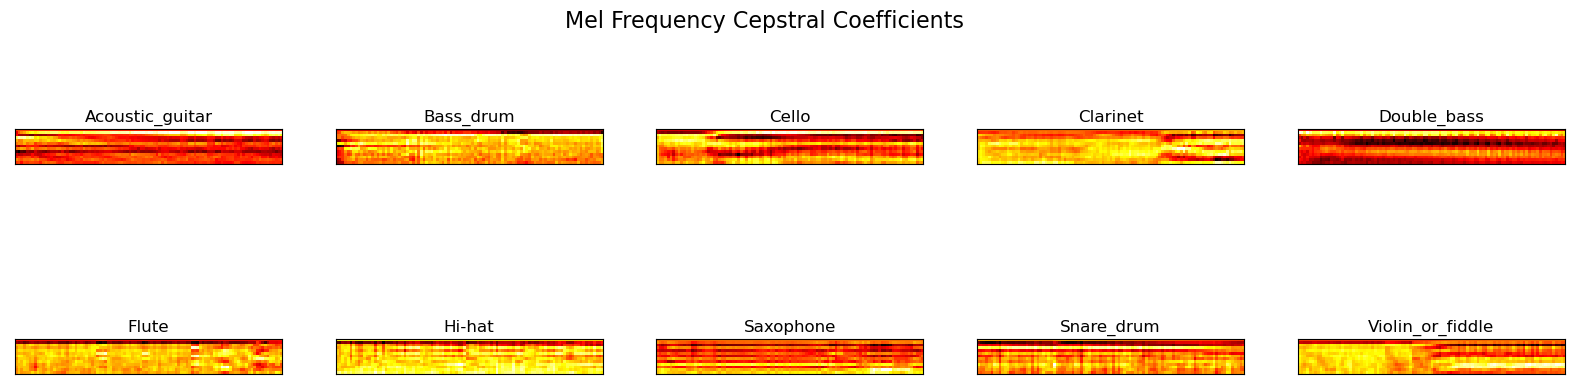

In [11]:
for c in classes:
    # Taking the first row/record/observation for each of the class labels
    wav_file = df[df.label == c].iloc[0,0]
    
    # Load the .wav file
    signal, rate = librosa.load('Audio-Classification/wavfiles/' + wav_file, sr=44100)
    
    signals[c] = signal
    fft[c] = calc_fft(signal, rate)
    bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T
    fbank[c] = bank
    mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T
    mfccs[c] = mel
    
plot_signals(signals)
plt.show()

plot_fft(fft)
plt.show()

plot_fbank(fbank)
plt.show()

plot_mfccs(mfccs)
plt.show()

# Data pre-processing

The key pre-processing task that we're performing here is a filtering process applied to the audio files, which includes removing those parts of the audio which do not cross a particular threshold value of amplitude.

In [12]:
def envelope(y, rate, threshold):
    mask = [] # Mask of true/false values
    y = pd.Series(y).apply(np.abs) # Convert to series
    y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean() # Rolling window over the data
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

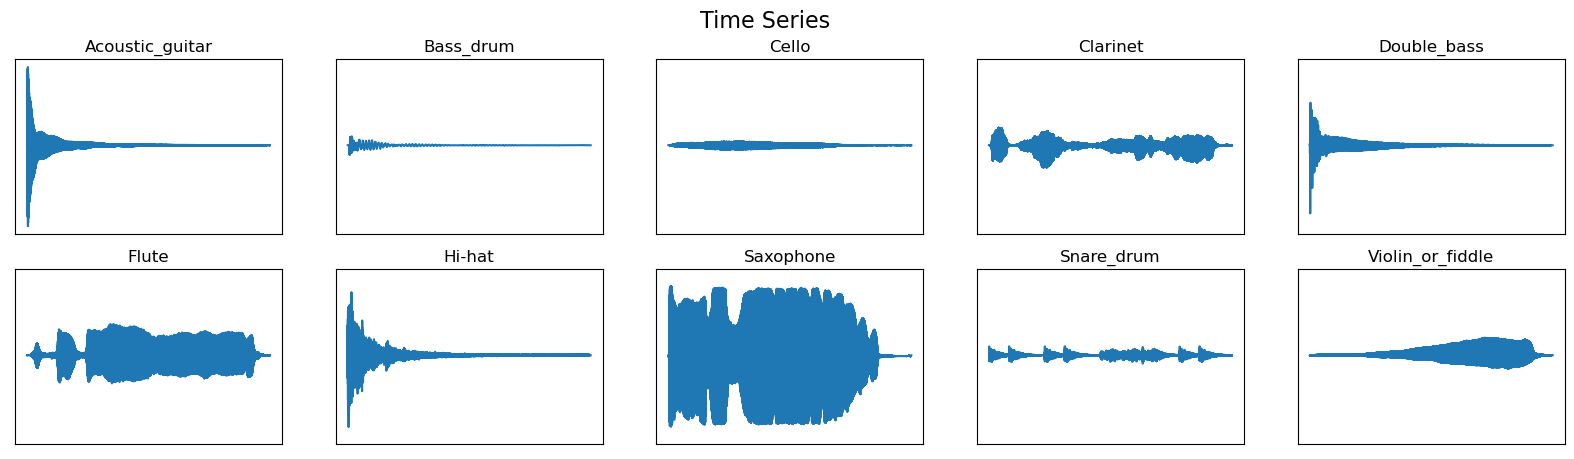

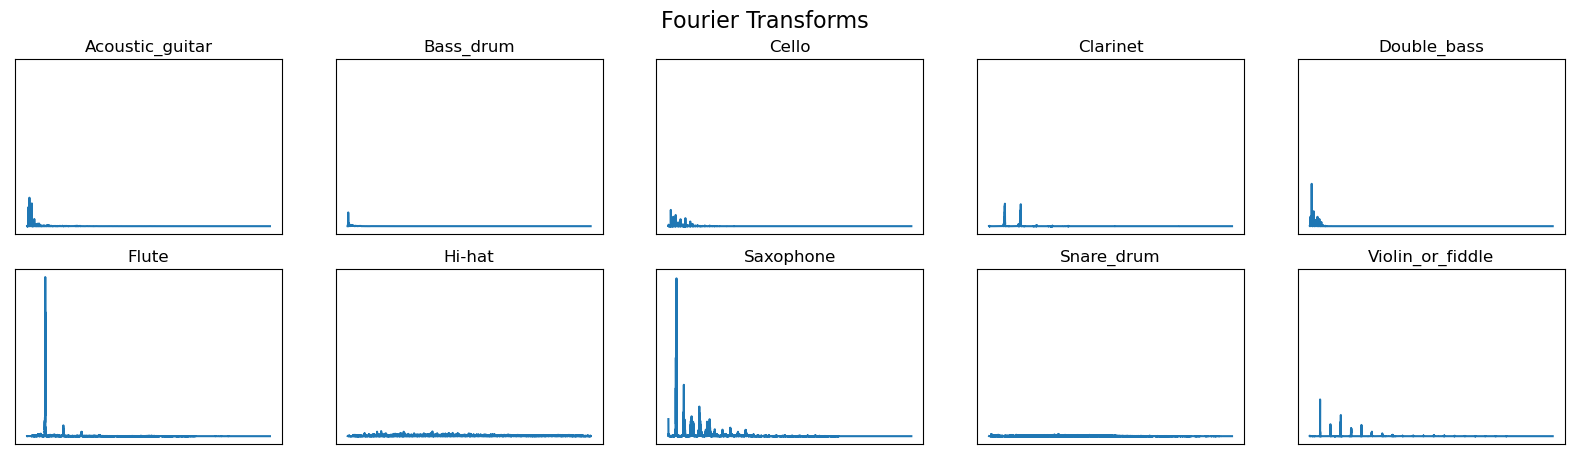

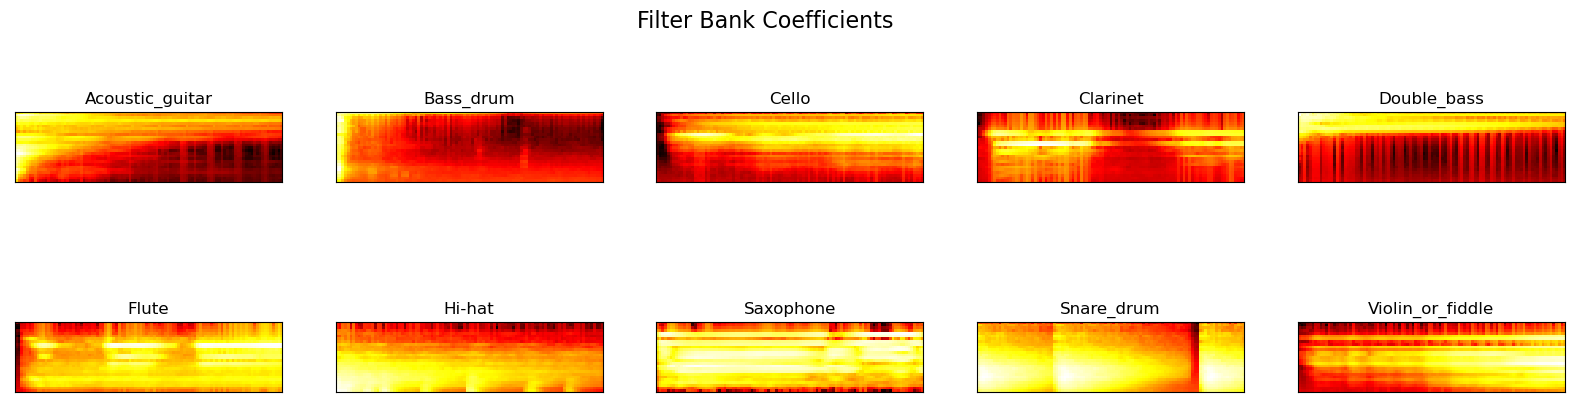

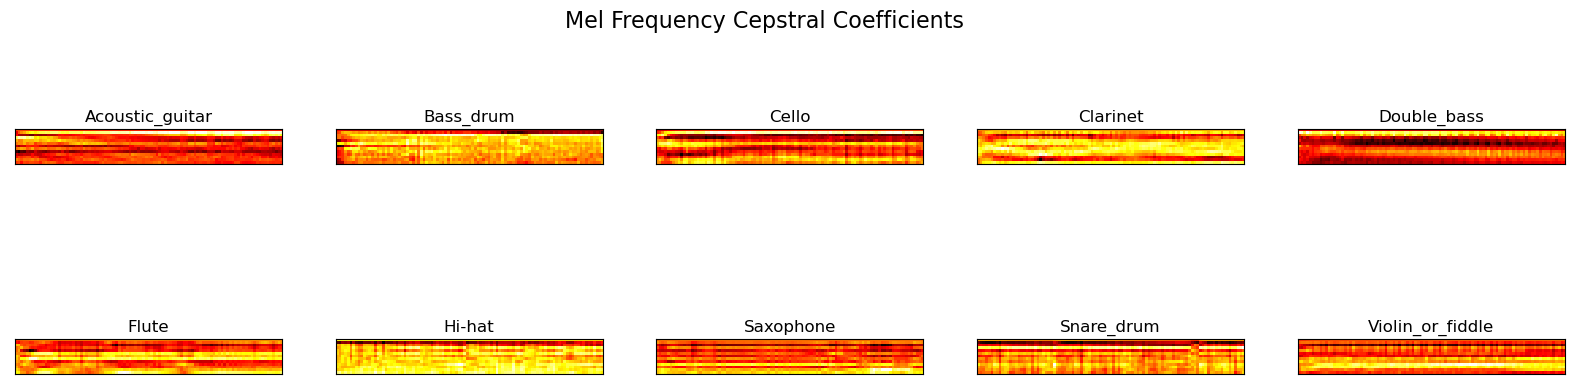

In [13]:
for c in classes:
    # Taking the first row/record/observation for each of the class labels
    wav_file = df[df.label == c].iloc[0,0]
    
    # Load the .wav file
    signal, rate = librosa.load('Audio-Classification/wavfiles/' + wav_file, sr=44100)
    mask = envelope(signal, rate, 0.0005)
    signal = signal[mask]
    signals[c] = signal
    fft[c] = calc_fft(signal, rate)
    bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T #nfft=sr/40, nfilt is the number of filters
    fbank[c] = bank
    mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T #numcep is the number of ceptrals after DCT of filterbank energies
    mfccs[c] = mel
    
plot_signals(signals)
plt.show()

plot_fft(fft)
plt.show()

plot_fbank(fbank)
plt.show()

plot_mfccs(mfccs)
plt.show()

In [14]:
%cd Audio-Classification
%mkdir clean
%cd ..

/kaggle/working/Audio-Classification
/kaggle/working


In [15]:
if len(os.listdir('Audio-Classification/clean')) == 0:
    for f in tqdm(df.fname):
        signal, rate = librosa.load('Audio-Classification/wavfiles/'+f, sr=16000) # Downsampling to 16k
        mask = envelope(signal, rate, 0.0005)
        wavfile.write(filename='Audio-Classification/clean/'+f, rate=rate, data=signal[mask])

100%|██████████| 300/300 [00:09<00:00, 32.25it/s]


In [16]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc

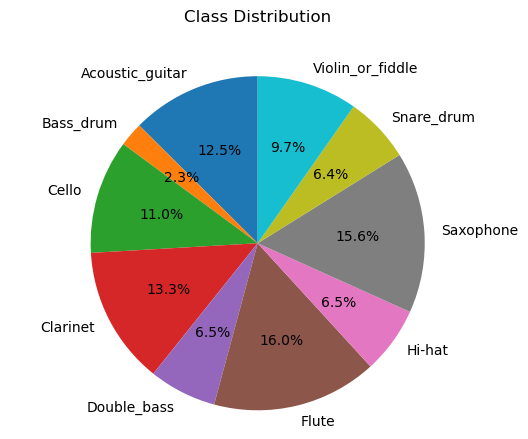

In [17]:
df = pd.read_csv('Audio-Classification/instruments.csv')
df.set_index('fname', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('Audio-Classification/clean/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

In [18]:
n_samples = 2 * int(df['length'].sum()/0.1)
prob_dist = class_dist / class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_dist)

### Probability distribution of classes

In [19]:
prob_dist

label
Acoustic_guitar     0.125477
Bass_drum           0.023364
Cello               0.110371
Clarinet            0.133400
Double_bass         0.065385
Flute               0.159951
Hi-hat              0.064675
Saxophone           0.155982
Snare_drum          0.064009
Violin_or_fiddle    0.097386
Name: length, dtype: float64

### Helper function to prepare data for modelling

The build_rand_feat() function prepares the set of features (X) and output variable (y) in a format which can be consumed by the deep learning model.

In [20]:
def build_rand_feat():
  X = []
  y = []
  _min, _max = float('inf'), -float('inf')
  for _ in tqdm(range(n_samples)):
    rand_class = np.random.choice(class_dist.index, p=prob_dist)
    file = np.random.choice(df[df.label==rand_class].index)
    rate, wav = wavfile.read('Audio-Classification/clean/'+file)
    label = df.at[file, 'label']
    rand_index = np.random.randint(0, wav.shape[0]-config.step)
    sample = wav[rand_index:rand_index + config.step]
    X_sample = mfcc(sample, 
                    rate, 
                    numcep=config.nfeat, 
                    nfilt=config.nfilt, nfft=config.nfft).T
    _min = min(np.amin(X_sample), _min)
    _max = max(np.amax(X_sample), _max)
    X.append(X_sample if config.mode =='conv' else X_sample.T)
    y.append(classes.index(label))
  X, y = np.array(X), np.array(y)
  X = (X - _min) / (_max - _min)
  if config.mode == 'conv':
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
  elif config.mode == 'recurr':
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
  y = to_categorical(y, num_classes=10)
  return X, y

# Baseline Convolutional Neural Network (CNN)

A common type of neural network for processing image and signal data, including audio data, is the convolutional neural network (CNN). Through a sequence of convolutional layers and pooling layers, a CNN is intended to automatically learn and extract features from raw input data.

A CNN can be used to assess audio signals in the context of audio data at various abstraction levels. For instance, the first layer of a CNN may identify low-level features like edges or frequency bands, while further layers may identify more intricate features like phonemes or musical notes.

The principal elements of a CNN for audio data are as follows:

<b>1. Convolutional layers:</b> These layers use a set of filters or kernels to extract important information from the audio source. Each filter is a tiny matrix that creates a feature map by convolving with the input signal. The final step is to run the generated feature maps through a non-linear activation function like ReLU.

<b>2. Pooling Layer:</b> Using a window of neighboring values, these layers take the maximum or average value and downsample the feature maps. As a result, the feature maps become less dimensional and the network becomes more resistant to changes in the input signal.

<b>3. Fully connected layers: </b> Convolutional and pooling layer output is combined in fully connected layers, which are then used to produce predictions. For classification problems, the completely linked layers could have activation functions like softmax.

<b>4. Dropout layers:</b> These layers randomly remove some neuronal connections during training, preventing overfitting and enhancing generalization abilities.

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*7YbBTqwF2dMAuQwOrD_hXQ.png)

Image source: https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5

In [21]:
%cd Audio-Classification
%mkdir result_files
%mkdir graphs_and_images
%mkdir models
%cd ..

/kaggle/working/Audio-Classification
/kaggle/working


## Defining the Config class

In [22]:
class Config:
  def __init__(self, mode='conv', nfilt=26, nfeat=13, nfft=512, rate=16000):
    self.mode = mode
    self.nfilt = nfilt
    self.nfeat = nfeat
    self.nfft = nfft
    self.rate = rate
    self.step = int(rate/10)

## Defining the CNN model architecture

In [23]:
def get_conv_model():
  model = Sequential()
  model.add(Conv2D(16, (3,3), activation='relu', strides=(1,1),
                   padding='same', input_shape=input_shape))
  model.add(Conv2D(32, (3,3), activation='relu', strides=(1,1),
                   padding='same'))
  model.add(Conv2D(64, (3,3), activation='relu', strides=(1,1),
                   padding='same'))
  model.add(Conv2D(128, (3,3), activation='relu', strides=(1,1),
                   padding='same'))
  model.add(MaxPool2D((2,2)))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  model.summary()
  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['acc'])
  return model

## Creating the Config object and creating corresponding model object

In [24]:
config = Config(mode='conv')
X, y = build_rand_feat()
y_flat = np.argmax(y, axis=1)
input_shape = (X.shape[1], X.shape[2], 1)
model_cnn = get_conv_model()

100%|██████████| 26404/26404 [00:52<00:00, 502.33it/s]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 9, 16)         160       
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 9, 32)         4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 9, 64)         18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 9, 128)        73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 4, 128)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 6, 4, 128)         0         
                                                        

## Dividing the dataset into train and test splits

In [25]:
df_eval_results_part_1 = pd.DataFrame(columns=['experiment','details','test_accuracy','training_time(s)'])
experiment_num = 0

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

class_weight = compute_class_weight('balanced',
                                    classes = np.unique(y_flat),
                                    y = y_flat)

class_weight = {i : class_weight[i] for i in range(len(class_weight))}

start = time.time()
model_cnn.fit(X_train, y_train, epochs=5, batch_size=32,
          shuffle=True, class_weight=class_weight)
end = time.time()
time_taken = round(end - start,2)

Epoch 1/5


2023-04-26 12:00:46.950103: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


578/578 [==============================] - 15s 6ms/step - loss: 1.0830 - acc: 0.5936
Epoch 2/5
578/578 [==============================] - 4s 6ms/step - loss: 0.5438 - acc: 0.7935
Epoch 3/5
578/578 [==============================] - 3s 6ms/step - loss: 0.4013 - acc: 0.8470
Epoch 4/5
578/578 [==============================] - 4s 7ms/step - loss: 0.3186 - acc: 0.8765
Epoch 5/5
578/578 [==============================] - 4s 6ms/step - loss: 0.2667 - acc: 0.8976


In [27]:
# evaluate the trained model on the test set
test_loss, test_acc = model_cnn.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')
print(f'Test loss: {test_loss}')

248/248 [==============================] - 1s 3ms/step - loss: 0.2734 - acc: 0.9071
Test accuracy: 0.9070941805839539
Test loss: 0.27344194054603577


In [28]:
df_eval_results_part_1 = pd.concat([df_eval_results_part_1,pd.DataFrame({'experiment':experiment_num, 'details':'Base CNN, 5 epochs', 'test_accuracy': test_acc, 'training_time(s)':time_taken},index=[0])])
experiment_num += 1

In [29]:
df_eval_results_part_1

,experiment,details,test_accuracy,training_time(s)
0,0,"Base CNN, 5 epochs",0.907094,42.41


In [30]:
model_cnn.save('Audio-Classification/models/baseline_cnn_original')

# Baseline Recurrent Neural Network (RNN)

The processing of sequential data using recurrent neural networks (RNNs) takes into account the temporal relationships between subsequent input samples.

The fundamental principle of an RNN is to feed the current time step's input with the output of the previous time step's computation. As a result, a feedback loop is created, enabling the network to retain knowledge about past inputs and utilize it to anticipate the inputs of the future. The recurrent layer, which consists of a group of recurrent neurons that retain an internal state vector that is updated at each time step, is the main part of an RNN. In the context of audio data, an RNN can be used to model the temporal dynamics of an audio signal and make predictions about future samples.

The principal elements of an RNN for audio data are as follows:

<b>1. Recurrent layer:</b> A group of recurrent neurons are present in this layer, and they keep an internal state vector that is updated each time a time step is taken. A non-linear activation function, such as a tanh or sigmoid, is applied to the recurrent layer's output.

<b>2. The input layer</b> receives the audio stream as input and converts it into a form that the recurrent layer can understand. Preprocessing techniques like feature extraction or normalization may be present in the input layer.

<b>3. Output layer:</b> Based on the internal state of the recurrent layer, this layer creates the output prediction. For classification problems, the output layer could use activation functions like softmax.

<b>4. Dropout layer: </b>During training, this layer randomly removes some of the connections between neurons, preventing overfitting and enhancing generalization abilities.

## Defining the RNN model architecture

In [31]:
def get_recurrent_model():
  model = Sequential()
  model.add(LSTM(128, return_sequences = True, input_shape=input_shape))
  model.add(LSTM(128, return_sequences = True))
  model.add(Dropout(0.5))
  model.add(TimeDistributed(Dense(64, activation='relu')))
  model.add(TimeDistributed(Dense(32, activation='relu')))
  model.add(TimeDistributed(Dense(16, activation='relu')))
  model.add(TimeDistributed(Dense(8, activation='relu')))
  model.add(Flatten())
  model.add(Dense(10, activation='softmax'))
  model.summary()
  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['acc'])
  return model

## Creating the Config object and creating corresponding model object

In [32]:
config = Config(mode='recurr')
X, y = build_rand_feat()
y_flat = np.argmax(y, axis=1)
input_shape = (X.shape[1], X.shape[2])
model_rnn = get_recurrent_model()

100%|██████████| 26404/26404 [00:53<00:00, 495.78it/s]


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 9, 128)            72704     
                                                                 
 lstm_1 (LSTM)               (None, 9, 128)            131584    
                                                                 
 dropout_1 (Dropout)         (None, 9, 128)            0         
                                                                 
 time_distributed (TimeDistr  (None, 9, 64)            8256      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 9, 32)            2080      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 9, 16)           

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

class_weight = compute_class_weight('balanced',
                                    classes = np.unique(y_flat),
                                    y = y_flat)

class_weight = {i : class_weight[i] for i in range(len(class_weight))}

start = time.time()
model_rnn.fit(X_train, y_train, epochs=5, batch_size=32,
          shuffle=True, class_weight=class_weight)
end = time.time()
time_taken = round(end - start,2)

Epoch 1/5
578/578 [==============================] - 12s 9ms/step - loss: 1.7621 - acc: 0.3063
Epoch 2/5
578/578 [==============================] - 5s 9ms/step - loss: 1.2714 - acc: 0.5071
Epoch 3/5
578/578 [==============================] - 6s 10ms/step - loss: 1.0058 - acc: 0.6162
Epoch 4/5
578/578 [==============================] - 5s 9ms/step - loss: 0.8830 - acc: 0.6640
Epoch 5/5
578/578 [==============================] - 5s 9ms/step - loss: 0.7982 - acc: 0.7002


In [34]:
# evaluate the trained model on the test set
test_loss, test_acc = model_rnn.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')
print(f'Test loss: {test_loss}')

248/248 [==============================] - 2s 4ms/step - loss: 0.8946 - acc: 0.6935
Test accuracy: 0.6935117244720459
Test loss: 0.8945648670196533


In [35]:
df_eval_results_part_1 = pd.concat([df_eval_results_part_1,pd.DataFrame({'experiment':experiment_num, 'details':'Base RNN, 5 epochs', 'test_accuracy': test_acc, 'training_time(s)':time_taken},index=[0])])
experiment_num += 1

In [36]:
df_eval_results_part_1

,experiment,details,test_accuracy,training_time(s)
0,0,"Base CNN, 5 epochs",0.907094,42.41
0,1,"Base RNN, 5 epochs",0.693512,45.00


In [37]:
model_rnn.save('Audio-Classification/models/baseline_rnn_original')

#### Saving the results in a CSV file

In [38]:
df_eval_results_part_1.to_csv('Audio-Classification/result_files/baseline_cnn_vs_rnn.csv',index=False,encoding='UTF-8')

# Optimizing the CNN model

Based on the above results, it is clear that the baseline CNN model performs better than the baseline RNN model. Therefore, we'll proceed with trying to optimize the CNN model.

## Method 1 - Manually testing and evaluating different hyper-parameters for CNN

### Number of training epochs

In [39]:
from sklearn.model_selection import train_test_split

config = Config(mode='conv')
X, y = build_rand_feat()
y_flat = np.argmax(y, axis=1)
input_shape = (X.shape[1], X.shape[2], 1)
model_cnn = get_conv_model()
  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

class_weight = compute_class_weight('balanced',
                                    classes = np.unique(y_flat),
                                    y = y_flat)

class_weight = {i : class_weight[i] for i in range(len(class_weight))}

df_eval_results_part_2 = pd.DataFrame(columns=['experiment','details','test_accuracy','training_time(s)'])
experiment_num = 0

for i in [5,7,10,15]:
    start = time.time()
    model_cnn.fit(X_train, y_train, epochs=i, batch_size=32,
          shuffle=True, class_weight=class_weight)
    end = time.time()
    time_taken = round(end-start,2)
    test_loss, test_acc = model_cnn.evaluate(X_test, y_test)
    print(f'Epochs: {i}')
    print(f'Test accuracy: {test_acc}')
    print(f'Test loss: {test_loss}')
    df_eval_results_part_2 = pd.concat([df_eval_results_part_2,pd.DataFrame({'experiment':experiment_num, 'details':str(i) + ' epochs', 'test_accuracy': test_acc, 'training_time(s)':time_taken},index=[0])]) 
    experiment_num += 1
    model_cnn.save('Audio-Classification/models/cnn_'+str(i)+'_epochs')

100%|██████████| 26404/26404 [00:53<00:00, 490.88it/s]


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 13, 9, 16)         160       
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 9, 32)         4640      
                                                                 
 conv2d_6 (Conv2D)           (None, 13, 9, 64)         18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 9, 128)        73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 4, 128)        0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 6, 4, 128)         0         
                                                      

2023-04-26 12:04:17.475033: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


578/578 [==============================] - 7s 8ms/step - loss: 1.2171 - acc: 0.5364
Epoch 2/5
578/578 [==============================] - 4s 6ms/step - loss: 0.6084 - acc: 0.7653
Epoch 3/5
578/578 [==============================] - 4s 6ms/step - loss: 0.4333 - acc: 0.8338
Epoch 4/5
578/578 [==============================] - 4s 7ms/step - loss: 0.3404 - acc: 0.8688
Epoch 5/5
248/248 [==============================] - 1s 4ms/step - loss: 0.2520 - acc: 0.9188
Epochs: 5
Test accuracy: 0.9188336133956909
Test loss: 0.2519500255584717
Epoch 1/7
578/578 [==============================] - 4s 7ms/step - loss: 0.2479 - acc: 0.9061
Epoch 2/7
578/578 [==============================] - 4s 6ms/step - loss: 0.2162 - acc: 0.9183
Epoch 3/7
578/578 [==============================] - 4s 6ms/step - loss: 0.1900 - acc: 0.9268
Epoch 4/7
578/578 [==============================] - 4s 7ms/step - loss: 0.1792 - acc: 0.9306
Epoch 5/7
578/578 [==============================] - 4s 6ms/step - loss: 0.1650 - acc: 0.9

In [40]:
df_eval_results_part_2.to_csv('Audio-Classification/result_files/cnn_epochs.csv',index=False,encoding='UTF-8')

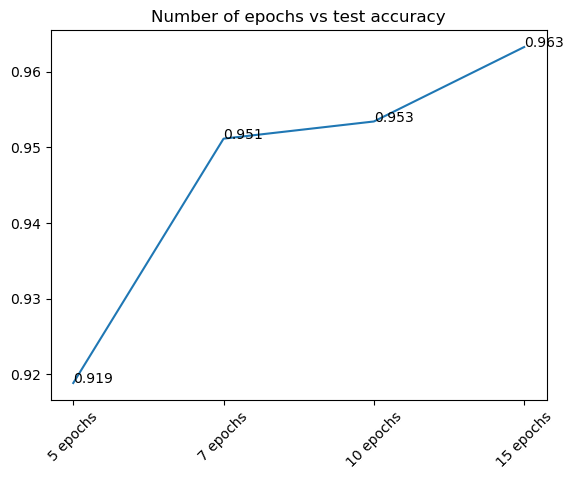

In [41]:
plt.plot(df_eval_results_part_2['details'], df_eval_results_part_2['test_accuracy'])
plt.xticks(rotation=45)
plt.title('Number of epochs vs test accuracy')
for x, y in zip(df_eval_results_part_2['details'], df_eval_results_part_2['test_accuracy']):
    plt.text(x = x, y = y, s = round(y,3))
plt.savefig('Audio-Classification/graphs_and_images/epochs_vs_test_accuracy.png')
plt.show()

Depending on a variety of variables, including the complexity of the dataset, the size of the network, the learning rate, and the regularization techniques employed, increasing the number of epochs can affect a CNN's performance in a variety of ways. Increasing the number of epochs could have the following effects:

1. Increased epochs can help the network better match the training data and achieve higher accuracy on the training set, which will improve training accuracy.

2. The network may start to memorize the training data if the number of epochs is too high, rather than learning generalizable features, which increases the risk of overfitting. As a result, the network may overfit, where it performs well on training data but poorly on untrained data.

3. Longer training period: If the dataset is vast or the network is complicated, increasing the number of epochs may lengthen the training period. Performance and computational resources may have to be traded off here.

4. Higher validation accuracy: The network may learn to generalize well to unseen data with a moderate number of epochs, resulting in higher validation accuracy. If the number of epochs is too high, this impact could saturate or even become less effective.

### Number of convolutional layers

In [42]:
from keras.utils.layer_utils import count_params

df_eval_results_part_3 = pd.DataFrame(columns=['experiment','details','test_accuracy', 'trainable_params','training_time(s)'])
experiment_num = 0

#### 4 convolutional layers

In [43]:
def get_conv_model():
  model = Sequential()
  model.add(Conv2D(16, (3,3), activation='relu', strides=(1,1),
                   padding='same', input_shape=input_shape))
  model.add(Conv2D(32, (3,3), activation='relu', strides=(1,1),
                   padding='same'))
  model.add(Conv2D(64, (3,3), activation='relu', strides=(1,1),
                   padding='same'))
  model.add(Conv2D(128, (3,3), activation='relu', strides=(1,1),
                   padding='same'))
  model.add(MaxPool2D((2,2)))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  model.summary()
  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['acc'])
  return model

config = Config(mode='conv')
X, y = build_rand_feat()
y_flat = np.argmax(y, axis=1)
input_shape = (X.shape[1], X.shape[2], 1)
model_cnn = get_conv_model()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

class_weight = compute_class_weight('balanced',
                                    classes = np.unique(y_flat),
                                    y = y_flat)

class_weight = {i : class_weight[i] for i in range(len(class_weight))}

start = time.time()
model_cnn.fit(X_train, y_train, epochs=5, batch_size=32,
          shuffle=True, class_weight=class_weight)
end = time.time()
time_taken = round(end-start,2)
test_loss, test_acc = model_cnn.evaluate(X_test, y_test)
trainable_count = count_params(model_cnn.trainable_weights)
df_eval_results_part_3 = pd.concat([df_eval_results_part_3,pd.DataFrame({'experiment':experiment_num, 'details':'Base CNN, 4 convolutions, 2 dense layers (128 & 64 units)', 'test_accuracy': test_acc, 'trainable_params':trainable_count,'training_time(s)': time_taken},index=[0])])
experiment_num += 1
model_cnn.save('Audio-Classification/models/cnn_4_conv_layers')

100%|██████████| 26404/26404 [00:52<00:00, 500.96it/s]


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 13, 9, 16)         160       
                                                                 
 conv2d_9 (Conv2D)           (None, 13, 9, 32)         4640      
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 9, 64)         18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 13, 9, 128)        73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 4, 128)        0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 6, 4, 128)         0         
                                                      

2023-04-26 12:07:41.988215: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


578/578 [==============================] - 6s 6ms/step - loss: 1.1757 - acc: 0.5500
Epoch 2/5
578/578 [==============================] - 4s 6ms/step - loss: 0.5988 - acc: 0.7750
Epoch 3/5
578/578 [==============================] - 4s 6ms/step - loss: 0.4365 - acc: 0.8371
Epoch 4/5
578/578 [==============================] - 4s 6ms/step - loss: 0.3494 - acc: 0.8667
Epoch 5/5
248/248 [==============================] - 1s 4ms/step - loss: 0.2542 - acc: 0.9174


In [44]:
df_eval_results_part_3

,experiment,details,test_accuracy,trainable_params,training_time(s)
0,0,"Base CNN, 4 convolutions, 2 dense layers (128 ...",0.917445,499402,20.75


#### 5 convolutional layers

In [45]:
def get_conv_model():
  model = Sequential()
  model.add(Conv2D(16, (3,3), activation='relu', strides=(1,1),
                   padding='same', input_shape=input_shape))
  model.add(Conv2D(32, (3,3), activation='relu', strides=(1,1),
                   padding='same'))
  model.add(Conv2D(64, (3,3), activation='relu', strides=(1,1),
                   padding='same'))
  model.add(Conv2D(128, (3,3), activation='relu', strides=(1,1),
                   padding='same'))
  model.add(Conv2D(256, (3,3), activation='relu', strides=(1,1),
                   padding='same'))
  model.add(MaxPool2D((2,2)))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  model.summary()
  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['acc'])
  return model

config = Config(mode='conv')
X, y = build_rand_feat()
y_flat = np.argmax(y, axis=1)
input_shape = (X.shape[1], X.shape[2], 1)
model_cnn = get_conv_model()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

class_weight = compute_class_weight('balanced',
                                    classes = np.unique(y_flat),
                                    y = y_flat)

class_weight = {i : class_weight[i] for i in range(len(class_weight))}

start = time.time()
model_cnn.fit(X_train, y_train, epochs=5, batch_size=32,
          shuffle=True, class_weight=class_weight)
end = time.time()
time_taken = round(end-start,2)
trainable_count = count_params(model_cnn.trainable_weights)
test_loss, test_acc = model_cnn.evaluate(X_test, y_test)
df_eval_results_part_3 = pd.concat([df_eval_results_part_3,pd.DataFrame({'experiment':experiment_num, 'details':'Non-Base CNN, 5 convolutions, 2 dense layers (256 & 128 units)', 'trainable_params':trainable_count,'test_accuracy': test_acc, 'training_time(s)':time_taken},index=[0])])
experiment_num += 1
model_cnn.save('Audio-Classification/models/cnn_5_conv_layers')

100%|██████████| 26404/26404 [00:52<00:00, 505.99it/s]


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 13, 9, 16)         160       
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 9, 32)         4640      
                                                                 
 conv2d_14 (Conv2D)          (None, 13, 9, 64)         18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 13, 9, 128)        73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 13, 9, 256)        295168    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 4, 256)        0         
 2D)                                                             
                                                      

2023-04-26 12:08:59.006346: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


578/578 [==============================] - 8s 7ms/step - loss: 1.1669 - acc: 0.5606
Epoch 2/5
578/578 [==============================] - 5s 8ms/step - loss: 0.5307 - acc: 0.7985
Epoch 3/5
578/578 [==============================] - 4s 7ms/step - loss: 0.3761 - acc: 0.8580
Epoch 4/5
578/578 [==============================] - 4s 7ms/step - loss: 0.2872 - acc: 0.8912
Epoch 5/5
248/248 [==============================] - 1s 4ms/step - loss: 0.2263 - acc: 0.9222


#### 6 convolutional layers

In [46]:
def get_conv_model():
  model = Sequential()
  model.add(Conv2D(16, (3,3), activation='relu', strides=(1,1),
                   padding='same', input_shape=input_shape))
  model.add(Conv2D(32, (3,3), activation='relu', strides=(1,1),
                   padding='same'))
  model.add(Conv2D(64, (3,3), activation='relu', strides=(1,1),
                   padding='same'))
  model.add(Conv2D(128, (3,3), activation='relu', strides=(1,1),
                   padding='same'))
  model.add(Conv2D(256, (3,3), activation='relu', strides=(1,1),
                   padding='same'))
  model.add(Conv2D(512, (3,3), activation='relu', strides=(1,1),
                   padding='same'))
  model.add(MaxPool2D((2,2)))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  model.summary()
  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['acc'])
  return model

config = Config(mode='conv')
X, y = build_rand_feat()
y_flat = np.argmax(y, axis=1)
input_shape = (X.shape[1], X.shape[2], 1)
model_cnn = get_conv_model()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

class_weight = compute_class_weight('balanced',
                                    classes = np.unique(y_flat),
                                    y = y_flat)

class_weight = {i : class_weight[i] for i in range(len(class_weight))}
start = time.time()
model_cnn.fit(X_train, y_train, epochs=5, batch_size=32,
          shuffle=True, class_weight=class_weight)
end = time.time()
time_taken = round(end-start,2)
test_loss, test_acc = model_cnn.evaluate(X_test, y_test)
trainable_count = count_params(model_cnn.trainable_weights)
df_eval_results_part_3 = pd.concat([df_eval_results_part_3,pd.DataFrame({'experiment':experiment_num, 'details':'Non-Base CNN, 6 convolutions, 2 dense layers (512 & 256 units)', 'trainable_params':trainable_count,'test_accuracy': test_acc, 'training_time(s)':time_taken},index=[0])])
experiment_num += 1
model_cnn.save('Audio-Classification/models/cnn_6_conv_layers')

100%|██████████| 26404/26404 [00:55<00:00, 479.46it/s]


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 13, 9, 16)         160       
                                                                 
 conv2d_18 (Conv2D)          (None, 13, 9, 32)         4640      
                                                                 
 conv2d_19 (Conv2D)          (None, 13, 9, 64)         18496     
                                                                 
 conv2d_20 (Conv2D)          (None, 13, 9, 128)        73856     
                                                                 
 conv2d_21 (Conv2D)          (None, 13, 9, 256)        295168    
                                                                 
 conv2d_22 (Conv2D)          (None, 13, 9, 512)        1180160   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 4, 512)       

2023-04-26 12:10:39.801256: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


578/578 [==============================] - 11s 12ms/step - loss: 1.1819 - acc: 0.5492
Epoch 2/5
578/578 [==============================] - 7s 12ms/step - loss: 0.5402 - acc: 0.7952
Epoch 3/5
578/578 [==============================] - 7s 12ms/step - loss: 0.3819 - acc: 0.8562
Epoch 4/5
578/578 [==============================] - 7s 12ms/step - loss: 0.2765 - acc: 0.8991
Epoch 5/5
248/248 [==============================] - 1s 5ms/step - loss: 0.2566 - acc: 0.9145


In [47]:
df_eval_results_part_3

,experiment,details,test_accuracy,trainable_params,training_time(s)
0,0,"Base CNN, 4 convolutions, 2 dense layers (128 ...",0.917445,499402,20.75
0,1,"Non-Base CNN, 5 convolutions, 2 dense layers (...",0.922242,1999626,43.16
0,2,"Non-Base CNN, 6 convolutions, 2 dense layers (...",0.914542,7998346,38.27


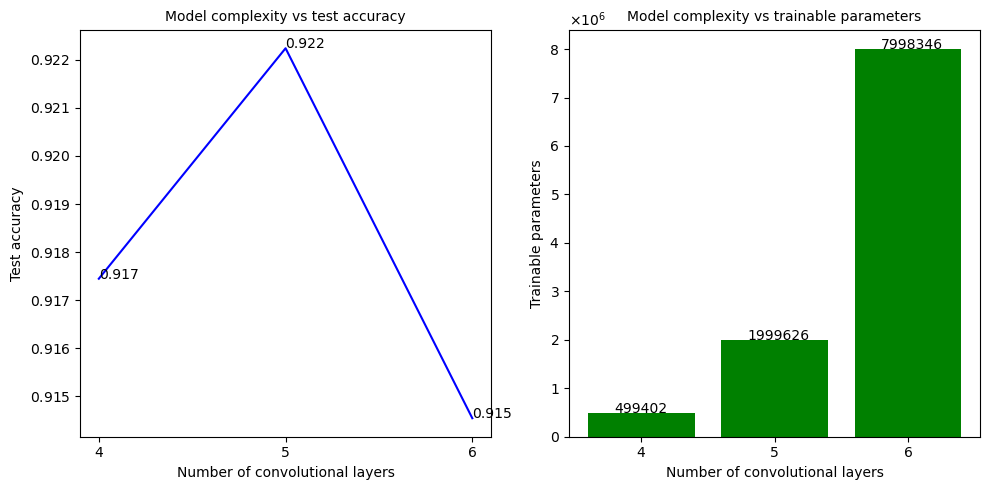

In [48]:
from matplotlib.ticker import ScalarFormatter
vals = [4,5,6]

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))



# Plot the line chart on the first subplot
ax1.plot(vals, df_eval_results_part_3['test_accuracy'], color='blue')
for x, y in zip(vals, df_eval_results_part_3['test_accuracy']):
    ax1.text(x = x, y = y, s = round(y,3))
ax1.set_xlabel('Number of convolutional layers')
ax1.set_ylabel('Test accuracy')
ax1.set_xticks(vals)
ax1.set_title('Model complexity vs test accuracy',fontsize=10)

# Plot the bar chart on the second subplot
ax2.bar(vals, df_eval_results_part_3['trainable_params'], color='green')
for x, y in zip(vals, df_eval_results_part_3['trainable_params']):
    ax2.text(x = x-0.2, y = y+3, s = round(y,3))
ax2.set_xlabel('Number of convolutional layers')
ax2.set_ylabel('Trainable parameters')
ax2.set_xticks(vals)
ax2.set_title('Model complexity vs trainable parameters',fontsize=10)

# Set the y-axis formatter to display actual values
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3,3)) # to set the threshold for scientific notation
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)

# Adjust the layout of the subplots
plt.tight_layout()

plt.savefig('Audio-Classification/graphs_and_images/model_complexity_vs_test_accuracy.png')
# Display the figure
plt.show()

As we increased the number of convolutional layers, the model complexity also increased. This meant that the network's trainable parameters increased exponentially, leading to longer training time but with improved test accuracy (uptil a certain extent).

## Method 2: Using the Keras Tuner library

Keras Tuner is an open-source library specifically built for hyper-paramater tuning of Keras-based deep learning models.

In [49]:
!pip install keras-tuner -q

In [50]:
import keras_tuner as kt

Reference: https://towardsdatascience.com/hyperparameter-tuning-with-kerastuner-and-tensorflow-c4a4d690b31a

In [51]:
input_shape = (X.shape[1], X.shape[2], 1)

def get_opt_conv_model(hp):
  model = Sequential()
  model.add(Conv2D(16, (3,3), activation='relu', strides=(1,1),
                   padding='same', input_shape=input_shape))
  model.add(Conv2D(32, (3,3), activation='relu', strides=(1,1),
                   padding='same'))
  model.add(Conv2D(64, (3,3), activation='relu', strides=(1,1),
                   padding='same'))
  model.add(Conv2D(128, (3,3), activation='relu', strides=(1,1),
                   padding='same'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  
  model.add(Dense(
                units=hp.Int("dense_layer_1", min_value=128, max_value=256, step=128),
                activation="relu")
            )
  model.add(Dropout(hp.Float("dropout_1", 0, 0.3, step=0.1)))

  model.add(Dense(10, activation='softmax'))

  # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3])
  #model.summary()
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.CategoricalCrossentropy(),
                  metrics=["accuracy"])
  return model

In [52]:
import tensorflow as tf
import keras
tuner = kt.Hyperband(get_opt_conv_model,
                     objective="val_accuracy",
                     max_epochs=5,
                     factor=3,
                     hyperband_iterations=2,
                     directory="instruments_dir",
                     project_name="Instruments",)

Hyper-parameter search space

In [53]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
dense_layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 128, 'sampling': None}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001], 'ordered': True}


The idea here is that Keras monitors the validation loss after each trial, and would stop the search process if there is no change in validation loss after 5 trials. This is the patience value.

In [54]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=5, validation_split=0.2, callbacks=[stop_early], verbose=2)

Trial 20 Complete [00h 00m 22s]
val_accuracy: 0.16689208149909973

Best val_accuracy So Far: 0.9020827412605286
Total elapsed time: 00h 04m 11s


In [55]:
# Get the optimal hyperparameters from the results
best_hps=tuner.get_best_hyperparameters()[0]

# Build model
h_model = tuner.hypermodel.build(best_hps)

# Train the hypertuned model
h_model.fit(X_train, y_train, epochs=5, validation_split=0.2, callbacks=[stop_early], verbose=2)

Epoch 1/5
463/463 - 4s - loss: 1.2055 - accuracy: 0.5650 - val_loss: 0.6755 - val_accuracy: 0.7666 - 4s/epoch - 8ms/step
Epoch 2/5
463/463 - 2s - loss: 0.5750 - accuracy: 0.8052 - val_loss: 0.4302 - val_accuracy: 0.8526 - 2s/epoch - 5ms/step
Epoch 3/5
463/463 - 2s - loss: 0.3957 - accuracy: 0.8618 - val_loss: 0.3643 - val_accuracy: 0.8815 - 2s/epoch - 5ms/step
Epoch 4/5
463/463 - 3s - loss: 0.3070 - accuracy: 0.8919 - val_loss: 0.2753 - val_accuracy: 0.9067 - 3s/epoch - 6ms/step
Epoch 5/5
463/463 - 3s - loss: 0.2582 - accuracy: 0.9096 - val_loss: 0.2877 - val_accuracy: 0.9067 - 3s/epoch - 6ms/step


In [56]:
test_loss, test_acc = h_model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')
print(f'Test loss: {test_loss}')

248/248 [==============================] - 1s 4ms/step - loss: 0.2799 - accuracy: 0.9073
Test accuracy: 0.9073466062545776
Test loss: 0.2798818051815033


In [57]:
h_model.save('Audio-Classification/models/cnn_keras_tuned')

# Model predictions

In [58]:
import pickle
from keras.callbacks import ModelCheckpoint

In [59]:
%cd Audio-Classification
%mkdir pickles
%cd ..

/kaggle/working/Audio-Classification
/kaggle/working


Refactoring the Config class - Additionally adding model_path and p_path attributes

In [60]:
import os
class Config:
  def __init__(self, mode='conv', nfilt=26, nfeat=13, nfft=512, rate=16000):
    self.mode = mode
    self.nfilt = nfilt
    self.nfeat = nfeat
    self.nfft = nfft
    self.rate = rate
    self.step = int(rate/10)
    self.model_path = os.path.join('Audio-Classification/models', mode +'.model')
    self.p_path = os.path.join('Audio-Classification/pickles', mode +'.p')

The check_data function will check whether there exists a pickle'd file for the processed training data.

In [61]:
def check_data():
    if os.path.isfile(config.p_path):
        print('Loading existing data for {} model'.format(config.mode))
        with open(config.p_path, 'rb') as handle:
            tmp = pickle.load(handle)
            return tmp
    else:
        return None

We are going to save the processed training data as a pickle file so that we don't have to process the training data again, each time we try to fit a new model.

Refactoring the build_rand_feat() function.

In [62]:
def build_rand_feat():
    tmp = check_data()
    if tmp:
        return tmp.data[0], tmp.data[1]
    X = []
    y = []
    _min, _max = float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index, p=prob_dist)
        file = np.random.choice(df[df.label==rand_class].index)
        rate, wav = wavfile.read('Audio-Classification/clean/'+file)
        label = df.at[file, 'label']
        rand_index = np.random.randint(0, wav.shape[0]-config.step)
        sample = wav[rand_index:rand_index + config.step]
        X_sample = mfcc(sample, 
                        rate, 
                        numcep=config.nfeat, 
                        nfilt=config.nfilt, nfft=config.nfft)
        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)
        X.append(X_sample)
        y.append(classes.index(label))
    config.min = _min
    config.max = _max
    X, y = np.array(X), np.array(y)
    X = (X - _min) / (_max - _min)
    if config.mode == 'conv':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    elif config.mode == 'recurr':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    y = to_categorical(y, num_classes=10)
    
    config.data = (X, y)
    
    # save the config object as a pickle file
    with open(config.p_path, 'wb') as handle:
        pickle.dump(config, handle, protocol=2)
    
    return X, y

Using the basline CNN model with the default 4 convolutional layers, but since we achieved the highest test accuracy with this model and 15 epochs, we'll use the same below.

In [63]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16, (3,3), activation='relu', strides=(1,1),
                       padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3,3), activation='relu', strides=(1,1),
                       padding='same'))
    model.add(Conv2D(64, (3,3), activation='relu', strides=(1,1),
                       padding='same'))
    model.add(Conv2D(128, (3,3), activation='relu', strides=(1,1),
                       padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['acc'])
    return model

In the below code, we're retraining the best model that we identified and saving it in the model path.

In [64]:
config = Config(mode='conv')
X, y = build_rand_feat()
y_flat = np.argmax(y, axis=1)
input_shape = (X.shape[1], X.shape[2], 1)
model_cnn = get_conv_model()
checkpoint = ModelCheckpoint(config.model_path,monitor='val_acc',
                            verbose=1, mode='max', save_best_only=True,
                            save_weights_only=False,period=1 )
model_cnn.fit(X, y, epochs=15, batch_size=32,
          shuffle=True, validation_split=0.1,
              callbacks=[checkpoint])

model_cnn.save(config.model_path)

100%|██████████| 26404/26404 [00:53<00:00, 497.05it/s]


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 9, 13, 16)         160       
                                                                 
 conv2d_9 (Conv2D)           (None, 9, 13, 32)         4640      
                                                                 
 conv2d_10 (Conv2D)          (None, 9, 13, 64)         18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 9, 13, 128)        73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 6, 128)        0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 4, 6, 128)         0         
                                                      

2023-04-26 12:17:03.437299: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


743/743 [==============================] - ETA: 0s - loss: 1.0166 - acc: 0.6358
Epoch 1: val_acc improved from -inf to 0.77471, saving model to Audio-Classification/models/conv.model
743/743 [==============================] - 10s 10ms/step - loss: 1.0166 - acc: 0.6358 - val_loss: 0.6471 - val_acc: 0.7747
Epoch 2/15
740/743 [============================>.] - ETA: 0s - loss: 0.4808 - acc: 0.8334
Epoch 2: val_acc improved from 0.77471 to 0.88716, saving model to Audio-Classification/models/conv.model
743/743 [==============================] - 6s 8ms/step - loss: 0.4807 - acc: 0.8334 - val_loss: 0.3417 - val_acc: 0.8872
Epoch 3/15
741/743 [============================>.] - ETA: 0s - loss: 0.3365 - acc: 0.8831
Epoch 3: val_acc improved from 0.88716 to 0.90799, saving model to Audio-Classification/models/conv.model
743/743 [==============================] - 6s 9ms/step - loss: 0.3365 - acc: 0.8831 - val_loss: 0.2612 - val_acc: 0.9080
Epoch 4/15
738/743 [============================>.] - ETA:

The below function prepares the data for prediction

In [65]:
from sklearn.metrics import accuracy_score
from keras.models import load_model

def build_predictions(audio_dir):
    y_true = []
    y_pred = []
    fn_prob = {}
    
    print('Extracting features from audio')
    for fn in tqdm(os.listdir(audio_dir)):
        rate, wav = wavfile.read(os.path.join(audio_dir,fn))
        label = fn2class[fn]
        c = classes.index(label)
        y_prob = []
        
        for i in range(0, wav.shape[0]-config.step,config.step):
            sample = wav[i:i+config.step]
            x = mfcc(sample, rate, numcep=config.nfeat,
                    nfilt=config.nfilt, nfft=config.nfft)
            x = (x-config.min)/(config.max-config.min)
            x = x.reshape(1,x.shape[0],x.shape[1],1)
            y_hat = model.predict(x)
            y_prob.append(y_hat)
            y_pred.append(np.argmax(y_hat))
            y_true.append(c)
        
        fn_prob[fn] = np.mean(y_prob, axis=0).flatten()
    
    return y_true, y_pred, fn_prob
            
df = pd.read_csv('Audio-Classification/instruments.csv')
classes = list(np.unique(df.label))
fn2class = dict(zip(df.fname, df.label))
p_path = os.path.join('Audio-Classification/pickles','conv.p')

with open(p_path, 'rb') as handle:
    config = pickle.load(handle)

model = load_model(config.model_path)

y_true, y_pred, fn_prob = build_predictions('Audio-Classification/clean')

y_probs = []

for i,row in df.iterrows():
    y_prob = fn_prob[row.fname]
    y_probs.append(y_prob)
    for c,p in zip(classes,y_prob):
        df.at[i,c] = p

y_pred = [classes[np.argmax(y)] for y in y_probs]
df['y_pred'] = y_pred

df.to_csv('Audio-Classification/result_files/predictions.csv', index=False)

Extracting features from audio


  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 1/300 [00:02<11:31,  2.31s/it]

1/1 [==============================] - 0s 25ms/step


  1%|          | 2/300 [00:07<18:52,  3.80s/it]

1/1 [==============================] - 0s 24ms/step


  1%|          | 3/300 [00:15<28:53,  5.84s/it]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 4/300 [00:17<22:18,  4.52s/it]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 5/300 [00:20<18:13,  3.71s/it]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 6/300 [00:22<15:33,  3.17s/it]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 7/300 [00:25<15:39,  3.21s/it]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 8/300 [00:26<12:02,  2.48s/it]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 9/300 [00:26<08:33,  1.77s/it]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 10/300 [00:30<10:48,  2.24s/it]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 11/300 [00:36<16:33,  3.44s/it]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 12/300 [00:38<14:32,  3.03s/it]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 13/300 [00:38<10:30,  2.20s/it]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 14/300 [00:38<07:55,  1.66s/it]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 15/300 [00:41<08:54,  1.88s/it]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 16/300 [00:42<08:05,  1.71s/it]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 17/300 [00:45<08:57,  1.90s/it]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 18/300 [00:45<06:42,  1.43s/it]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 19/300 [00:55<19:04,  4.07s/it]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 20/300 [00:57<15:40,  3.36s/it]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 21/300 [00:58<12:27,  2.68s/it]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 22/300 [01:01<13:27,  2.91s/it]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 23/300 [01:07<17:23,  3.77s/it]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 24/300 [01:07<12:40,  2.76s/it]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 25/300 [01:10<12:00,  2.62s/it]

1/1 [==============================] - 0s 23ms/step


  9%|▊         | 26/300 [01:12<11:47,  2.58s/it]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 27/300 [01:14<10:12,  2.24s/it]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 28/300 [01:16<10:02,  2.22s/it]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 29/300 [01:17<08:05,  1.79s/it]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 30/300 [01:19<08:36,  1.91s/it]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 31/300 [01:24<13:34,  3.03s/it]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 32/300 [01:30<16:54,  3.79s/it]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 33/300 [01:32<14:36,  3.28s/it]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 34/300 [01:33<10:44,  2.42s/it]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 35/300 [01:33<07:50,  1.78s/it]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 36/300 [01:37<11:11,  2.54s/it]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 37/300 [01:39<09:35,  2.19s/it]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 38/300 [01:45<14:55,  3.42s/it]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 39/300 [01:51<18:27,  4.24s/it]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 40/300 [01:52<14:44,  3.40s/it]

1/1 [==============================] - 0s 25ms/step


 14%|█▎        | 41/300 [01:54<12:01,  2.79s/it]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 42/300 [02:00<16:19,  3.80s/it]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 43/300 [02:05<18:28,  4.31s/it]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 44/300 [02:08<16:19,  3.83s/it]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 45/300 [02:10<13:36,  3.20s/it]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 46/300 [02:10<09:51,  2.33s/it]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 47/300 [02:13<10:26,  2.48s/it]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 48/300 [02:15<10:15,  2.44s/it]

1/1 [==============================] - 0s 24ms/step


 16%|█▋        | 49/300 [02:23<16:14,  3.88s/it]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 50/300 [02:29<18:41,  4.49s/it]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 51/300 [02:31<15:50,  3.82s/it]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 52/300 [02:45<28:20,  6.86s/it]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 53/300 [02:49<24:41,  6.00s/it]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 54/300 [02:51<20:21,  4.96s/it]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 55/300 [02:53<16:01,  3.92s/it]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 56/300 [02:54<12:45,  3.14s/it]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 57/300 [02:57<12:13,  3.02s/it]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 58/300 [02:58<09:42,  2.41s/it]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 59/300 [03:09<19:59,  4.98s/it]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 60/300 [03:11<16:23,  4.10s/it]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 61/300 [03:13<14:02,  3.53s/it]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 62/300 [03:14<11:10,  2.82s/it]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 63/300 [03:15<08:42,  2.20s/it]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 64/300 [03:16<07:25,  1.89s/it]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 65/300 [03:17<05:49,  1.49s/it]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 66/300 [03:20<08:00,  2.06s/it]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 67/300 [03:21<06:24,  1.65s/it]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 68/300 [03:23<07:39,  1.98s/it]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 69/300 [03:24<05:45,  1.49s/it]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 70/300 [03:28<08:31,  2.23s/it]

1/1 [==============================] - 0s 25ms/step


 24%|██▎       | 71/300 [03:32<10:27,  2.74s/it]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 72/300 [03:34<09:43,  2.56s/it]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 73/300 [03:35<07:56,  2.10s/it]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 74/300 [03:40<10:56,  2.90s/it]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 75/300 [03:41<09:38,  2.57s/it]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 76/300 [03:43<08:45,  2.34s/it]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 77/300 [03:43<06:21,  1.71s/it]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 78/300 [03:46<06:49,  1.85s/it]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 79/300 [03:49<08:06,  2.20s/it]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 80/300 [03:49<06:06,  1.67s/it]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 81/300 [03:52<07:34,  2.08s/it]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 82/300 [03:57<10:50,  2.98s/it]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 83/300 [04:00<10:44,  2.97s/it]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 84/300 [04:06<13:28,  3.74s/it]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 85/300 [04:08<11:37,  3.25s/it]

1/1 [==============================] - 0s 32ms/step


 29%|██▊       | 86/300 [04:11<11:04,  3.10s/it]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 87/300 [04:11<08:23,  2.37s/it]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 88/300 [04:14<08:29,  2.40s/it]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 89/300 [04:17<09:02,  2.57s/it]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 90/300 [04:23<12:42,  3.63s/it]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 91/300 [04:25<10:57,  3.14s/it]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 92/300 [04:29<12:15,  3.54s/it]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 93/300 [04:32<11:40,  3.39s/it]

1/1 [==============================] - 0s 24ms/step


 31%|███▏      | 94/300 [04:35<10:54,  3.18s/it]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 95/300 [04:37<10:05,  2.96s/it]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 96/300 [04:38<07:27,  2.19s/it]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 97/300 [04:39<06:08,  1.81s/it]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 98/300 [04:45<10:30,  3.12s/it]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 99/300 [04:48<09:58,  2.98s/it]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 100/300 [04:50<09:07,  2.74s/it]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 101/300 [04:55<12:03,  3.64s/it]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 102/300 [04:56<09:14,  2.80s/it]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 103/300 [04:57<07:35,  2.31s/it]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 104/300 [04:58<05:57,  1.83s/it]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 105/300 [04:59<04:49,  1.49s/it]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 106/300 [05:12<15:52,  4.91s/it]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 107/300 [05:18<16:49,  5.23s/it]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 108/300 [05:22<15:36,  4.88s/it]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 109/300 [05:24<13:11,  4.15s/it]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 110/300 [05:27<11:47,  3.73s/it]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 111/300 [05:31<12:04,  3.84s/it]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 112/300 [05:42<18:50,  6.01s/it]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 113/300 [05:47<17:44,  5.69s/it]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 114/300 [05:49<14:12,  4.58s/it]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 115/300 [05:56<16:01,  5.20s/it]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 116/300 [05:58<13:06,  4.28s/it]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 117/300 [05:58<09:26,  3.10s/it]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 118/300 [05:59<06:56,  2.29s/it]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 119/300 [06:01<06:49,  2.26s/it]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 120/300 [06:04<07:51,  2.62s/it]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 121/300 [06:10<10:29,  3.52s/it]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 122/300 [06:12<09:19,  3.15s/it]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 123/300 [06:13<06:55,  2.35s/it]

1/1 [==============================] - 0s 39ms/step


 41%|████▏     | 124/300 [06:17<08:32,  2.91s/it]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 125/300 [06:22<10:38,  3.65s/it]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 126/300 [06:27<11:14,  3.88s/it]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 127/300 [06:31<11:29,  3.98s/it]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 128/300 [06:31<08:10,  2.85s/it]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 129/300 [06:38<11:28,  4.02s/it]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 130/300 [06:43<12:12,  4.31s/it]

1/1 [==============================] - 0s 35ms/step


 44%|████▎     | 131/300 [06:48<12:47,  4.54s/it]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 132/300 [06:53<12:53,  4.60s/it]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 133/300 [06:59<14:11,  5.10s/it]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 134/300 [07:02<12:10,  4.40s/it]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 135/300 [07:04<10:13,  3.72s/it]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 136/300 [07:05<08:01,  2.94s/it]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 137/300 [07:09<09:03,  3.33s/it]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 138/300 [07:15<10:49,  4.01s/it]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 139/300 [07:17<09:10,  3.42s/it]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 140/300 [07:19<08:10,  3.07s/it]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 141/300 [07:21<07:13,  2.73s/it]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 142/300 [07:30<12:28,  4.73s/it]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 143/300 [07:31<09:09,  3.50s/it]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 144/300 [07:35<09:49,  3.78s/it]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 145/300 [07:40<10:02,  3.89s/it]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 146/300 [07:43<09:37,  3.75s/it]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 147/300 [07:52<13:35,  5.33s/it]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 148/300 [07:54<11:18,  4.46s/it]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 149/300 [07:59<10:53,  4.33s/it]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 150/300 [08:02<10:12,  4.09s/it]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 151/300 [08:09<12:37,  5.08s/it]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 152/300 [08:10<09:13,  3.74s/it]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 153/300 [08:13<08:23,  3.43s/it]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 154/300 [08:16<08:23,  3.45s/it]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 155/300 [08:23<10:37,  4.40s/it]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 156/300 [08:24<08:20,  3.48s/it]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 157/300 [08:25<06:17,  2.64s/it]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 158/300 [08:29<07:02,  2.98s/it]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 159/300 [08:36<09:49,  4.18s/it]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 160/300 [08:42<11:24,  4.89s/it]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 161/300 [08:47<10:59,  4.75s/it]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 162/300 [08:52<11:41,  5.08s/it]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 163/300 [08:54<09:04,  3.97s/it]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 164/300 [08:58<09:17,  4.10s/it]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 165/300 [09:00<07:47,  3.46s/it]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 166/300 [09:00<05:36,  2.51s/it]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 167/300 [09:01<04:04,  1.84s/it]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 168/300 [09:04<04:59,  2.27s/it]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 169/300 [09:04<03:41,  1.69s/it]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 170/300 [09:15<09:28,  4.37s/it]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 171/300 [09:18<08:23,  3.90s/it]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 172/300 [09:20<07:21,  3.45s/it]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 173/300 [09:22<06:29,  3.07s/it]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 174/300 [09:28<08:21,  3.98s/it]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 175/300 [09:31<07:38,  3.67s/it]

1/1 [==============================] - 0s 32ms/step


 59%|█████▊    | 176/300 [09:35<07:41,  3.72s/it]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 177/300 [09:36<05:41,  2.77s/it]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 178/300 [09:36<04:10,  2.06s/it]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 179/300 [09:44<07:28,  3.71s/it]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 180/300 [09:44<05:24,  2.71s/it]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 181/300 [09:49<06:32,  3.30s/it]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 182/300 [09:51<05:50,  2.97s/it]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 183/300 [09:56<06:56,  3.56s/it]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 184/300 [09:56<05:02,  2.61s/it]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 185/300 [09:58<04:37,  2.41s/it]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 186/300 [09:59<03:26,  1.81s/it]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 187/300 [10:00<03:00,  1.60s/it]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 188/300 [10:06<05:24,  2.90s/it]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 189/300 [10:09<05:24,  2.93s/it]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 190/300 [10:17<08:05,  4.42s/it]

1/1 [==============================] - 0s 27ms/step


 64%|██████▎   | 191/300 [10:18<06:24,  3.53s/it]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 192/300 [10:20<05:32,  3.08s/it]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 193/300 [10:22<04:53,  2.74s/it]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 194/300 [10:28<06:45,  3.83s/it]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 195/300 [10:30<05:36,  3.20s/it]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 196/300 [10:33<05:15,  3.03s/it]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 197/300 [10:33<03:49,  2.23s/it]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 198/300 [10:36<04:02,  2.38s/it]

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 199/300 [10:39<04:18,  2.56s/it]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 200/300 [10:43<05:05,  3.05s/it]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 201/300 [10:47<05:38,  3.42s/it]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 202/300 [10:49<04:29,  2.75s/it]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 203/300 [10:50<04:01,  2.49s/it]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 204/300 [10:54<04:24,  2.76s/it]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 205/300 [10:57<04:29,  2.83s/it]

1/1 [==============================] - 0s 25ms/step


 69%|██████▊   | 206/300 [10:57<03:16,  2.09s/it]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 207/300 [10:59<03:10,  2.05s/it]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 208/300 [11:02<03:31,  2.30s/it]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 209/300 [11:02<02:36,  1.72s/it]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 210/300 [11:04<02:36,  1.74s/it]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 211/300 [11:07<02:53,  1.95s/it]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 212/300 [11:12<04:27,  3.04s/it]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 213/300 [11:15<04:29,  3.10s/it]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 214/300 [11:19<04:38,  3.24s/it]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 215/300 [11:24<05:26,  3.84s/it]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 216/300 [11:35<08:19,  5.94s/it]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 217/300 [11:38<07:01,  5.07s/it]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 218/300 [11:39<05:01,  3.68s/it]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 219/300 [11:44<05:47,  4.29s/it]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 220/300 [11:49<06:02,  4.53s/it]

1/1 [==============================] - 0s 25ms/step


 74%|███████▎  | 221/300 [11:50<04:24,  3.35s/it]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 222/300 [11:50<03:08,  2.41s/it]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 223/300 [11:53<03:26,  2.68s/it]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 224/300 [11:54<02:45,  2.18s/it]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 225/300 [11:57<02:41,  2.16s/it]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 226/300 [11:58<02:27,  1.99s/it]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 227/300 [11:59<01:48,  1.49s/it]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 228/300 [12:02<02:25,  2.03s/it]

1/1 [==============================] - 0s 37ms/step


 76%|███████▋  | 229/300 [12:05<02:40,  2.26s/it]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 230/300 [12:06<02:28,  2.12s/it]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 231/300 [12:08<02:11,  1.90s/it]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 232/300 [12:10<02:14,  1.98s/it]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 233/300 [12:12<02:06,  1.88s/it]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 234/300 [12:16<02:58,  2.70s/it]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 235/300 [12:20<03:13,  2.98s/it]

1/1 [==============================] - 0s 24ms/step


 79%|███████▊  | 236/300 [12:22<02:45,  2.59s/it]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 237/300 [12:26<03:14,  3.09s/it]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 238/300 [12:31<03:45,  3.63s/it]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 239/300 [12:33<03:14,  3.18s/it]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 240/300 [12:36<03:16,  3.27s/it]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 241/300 [12:37<02:29,  2.53s/it]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 242/300 [12:42<03:08,  3.25s/it]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 243/300 [12:43<02:32,  2.68s/it]

1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 244/300 [12:46<02:37,  2.81s/it]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 245/300 [12:47<01:57,  2.13s/it]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 246/300 [12:47<01:23,  1.55s/it]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 247/300 [12:52<02:13,  2.51s/it]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 248/300 [13:03<04:20,  5.02s/it]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 249/300 [13:05<03:32,  4.16s/it]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 250/300 [13:05<02:31,  3.03s/it]

1/1 [==============================] - 0s 40ms/step


 84%|████████▎ | 251/300 [13:08<02:23,  2.93s/it]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 252/300 [13:11<02:23,  2.98s/it]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 253/300 [13:11<01:40,  2.13s/it]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 254/300 [13:19<02:54,  3.79s/it]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 255/300 [13:23<02:58,  3.97s/it]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 256/300 [13:26<02:38,  3.61s/it]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 257/300 [13:29<02:22,  3.32s/it]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 258/300 [13:29<01:41,  2.41s/it]

1/1 [==============================] - 0s 42ms/step


 86%|████████▋ | 259/300 [13:31<01:36,  2.35s/it]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 260/300 [13:39<02:34,  3.85s/it]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 261/300 [13:40<01:55,  2.96s/it]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 262/300 [13:43<01:53,  2.98s/it]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 263/300 [13:45<01:41,  2.75s/it]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 264/300 [13:47<01:33,  2.59s/it]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 265/300 [13:50<01:34,  2.70s/it]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 266/300 [13:50<01:07,  1.97s/it]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 267/300 [13:52<01:00,  1.83s/it]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 268/300 [13:54<00:59,  1.87s/it]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 269/300 [13:54<00:43,  1.41s/it]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 270/300 [14:07<02:25,  4.85s/it]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 271/300 [14:10<02:06,  4.35s/it]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 272/300 [14:14<01:54,  4.11s/it]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 273/300 [14:17<01:48,  4.01s/it]

1/1 [==============================] - 0s 24ms/step


 91%|█████████▏| 274/300 [14:20<01:31,  3.52s/it]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 275/300 [14:21<01:09,  2.76s/it]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 276/300 [14:21<00:49,  2.06s/it]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 277/300 [14:23<00:43,  1.91s/it]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 278/300 [14:26<00:49,  2.23s/it]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 279/300 [14:27<00:40,  1.91s/it]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 280/300 [14:29<00:38,  1.95s/it]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▎| 281/300 [14:31<00:38,  2.00s/it]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 282/300 [14:34<00:41,  2.29s/it]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▍| 283/300 [14:37<00:44,  2.64s/it]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 284/300 [14:39<00:36,  2.26s/it]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 285/300 [14:41<00:33,  2.22s/it]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 286/300 [14:41<00:23,  1.66s/it]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 287/300 [14:47<00:37,  2.92s/it]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 288/300 [14:48<00:25,  2.15s/it]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 289/300 [14:57<00:47,  4.28s/it]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 290/300 [14:59<00:37,  3.76s/it]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 291/300 [15:02<00:30,  3.44s/it]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 292/300 [15:07<00:32,  4.03s/it]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 293/300 [15:10<00:25,  3.67s/it]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 294/300 [15:16<00:25,  4.25s/it]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 295/300 [15:18<00:17,  3.59s/it]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▊| 296/300 [15:19<00:10,  2.68s/it]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 297/300 [15:22<00:08,  2.89s/it]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 298/300 [15:29<00:08,  4.27s/it]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 299/300 [15:33<00:04,  4.00s/it]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 300/300 [15:37<00:00,  3.12s/it]


In [66]:
pd.set_option('display.float_format', '{:.3f}'.format)
df

,fname,label,Acoustic_guitar,Bass_drum,Cello,Clarinet,Double_bass,Flute,Hi-hat,Saxophone,Snare_drum,Violin_or_fiddle,y_pred
0,5388d14d.wav,Saxophone,0.000,0.009,0.001,0.000,0.000,0.017,0.000,0.957,0.000,0.016,Saxophone
1,c685f05f.wav,Saxophone,0.000,0.000,0.005,0.001,0.000,0.000,0.000,0.989,0.003,0.001,Saxophone
2,36d20ab5.wav,Saxophone,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.995,0.004,0.000,Saxophone
3,d6665734.wav,Saxophone,0.000,0.000,0.012,0.000,0.002,0.005,0.000,0.973,0.004,0.004,Saxophone
4,7352e28f.wav,Saxophone,0.000,0.000,0.000,0.000,0.000,0.012,0.000,0.988,0.000,0.000,Saxophone
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,3c713bcf.wav,Clarinet,0.000,0.000,0.001,0.998,0.000,0.000,0.000,0.001,0.000,0.000,Clarinet
296,2fc00271.wav,Clarinet,0.000,0.000,0.000,0.995,0.000,0.000,0.000,0.000,0.000,0.005,Clarinet
297,b0c06255.wav,Clarinet,0.002,0.000,0.000,0.994,0.000,0.004,0.000,0.001,0.000,0.000,Clarinet
298,71c6451f.wav,Clarinet,0.000,0.000,0.000,0.975,0.000,0.022,0.000,0.003,0.000,0.000,Clarinet


# Results and key conclusions

The results and key conclusions are as follows:

1. The baseline convolutional neural network outperformed the baseline recurrent neural network

2. Based on the optimization techniques:

    i) Increasing the number of training epochs resulted in an improvement in test accuracy. It means that the weights and biases were optimized more often as we increased the epochs. Although, this comes with a caveat that there is only a certain peak performance that we can achieve through just by increasing the number of epochs.
    
    ii) Increasing the model complexity also increased the test accuracy in the models. This comes with the tradeoff with training time and the number of trainable parameters in the model.
    
    iii) The same optimization process can be done through an inbuilt library which is keras-tuner. It is specifically built for keras based deep learning models. It is more flexible in the sense that it provides various options for hyper-parameter tuning including number of hidden layers, dropout thresholds, algorithm optimizer to be used and so on
   
3. The best model observed was the 15-epoch CNN model with 4 convolutional layers and 2 hidden layers. It's test accuracy was 96.3% compared to the baseline CNN model which showed a test accuracy of 90.7%

4. All the models, result files, diagrams and predictions were saved in their respective folders for future reference. The predictions helped us understand the probabilities of choosing the corresponding output class label for the instruments.

5. Overall, CNNs turned out to be much better than RNNs for this specific project. It is due to the fact that CNNs generally perform very well for image based inputs. In our case, the inputs to the CNNs were the MFCCs.